# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [237]:
# Load pickled data
import pickle
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.contrib.layers import flatten, l2_regularizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from random import randint, choice

# TODO: Fill this in based on where you saved the training and testing data

training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [238]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

27


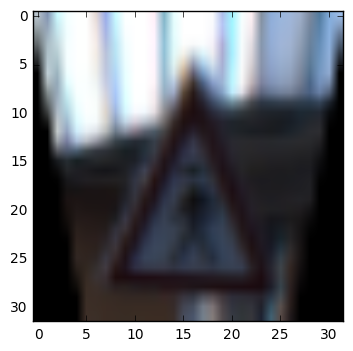

In [277]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
from collections import Counter
# Visualizations will be shown in the notebook.
%matplotlib inline

sign_num = 30710
pic = X_train[sign_num]
print(y_train[sign_num])

src = np.array([
    [0, 0],
    [31, 0],
    [31, 31],
    [0,31]],
    dtype="float32")

dst = np.array([
    [0, 0],
    [31, 0],
    [26, 31],
    [5, 31]],
    dtype="float32")

M = cv2.getPerspectiveTransform(src, dst)

pic = cv2.warpPerspective(pic, M, (32, 32))
plt.imshow(pic)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [226]:
def convert_rgb_to_just_y(X):
    '''
    converts rgb image to yuv, then just returns y channel
    '''
    X_y = np.copy(X)
    X_y = X_y[:,:,:,0].reshape(len(X), 32, 32, 1)
    for i in range(len(X)):
        img = cv2.cvtColor(X[i], cv2.COLOR_BGR2YUV)
        X_y[i] = img[:,:,0].reshape(32, 32, 1)
        
    return X_y

X_train = convert_rgb_to_just_y(X_train)
X_test = convert_rgb_to_just_y(X_test)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I converted the images to YUV, and then only used the Y channel - this makes the model faster to train, and also results in higher validation accuracy than using RGB or YUV channels.

In [227]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
def jitter_training_set(X, y):
    '''
    creates "jittered" data by adding copies of the training images that are
    randomly translated, rotated, and resized
    '''
    X_jittered = np.concatenate((X,)*5, axis=0)
    y_jittered = np.concatenate((y,)*5, axis=0)
    
    # loop over the augmented data, and do a different transformation
    # on each new data set
    for i in range(len(X), len(X_jittered)):
        
        img = X_jittered[i]
        
        #rotate
        rot = randint(-10, 10)
        M_rot = cv2.getRotationMatrix2D((16, 16), rot, 1)
        img = cv2.warpAffine(img, M_rot, (32, 32))

        # translate
        trans_h = randint(-3, 3)
        trans_v = randint(-3, 3)
        M_trans = np.float32([[1,0,trans_h],[0,1,trans_v]])
        img = cv2.warpAffine(img, M_trans, (32, 32))

        # warp perspective left, right, up, or down
        warp_dir = choice(["left", "right", "up", "down"])

        if warp_dir == "left":
            warp = randint(1, 5)
            src = np.array([[0, 0], [31, 0], [31, 31], [0,31]], dtype="float32")
            dst = np.array([[0, warp], [31, 0], [31, 31], [0, 31-warp]], dtype="float32")
            M = cv2.getPerspectiveTransform(src, dst)
            img = cv2.warpPerspective(img, M, (32, 32))

        elif warp_dir == "right":
            warp = randint(1, 5)
            src = np.array([[0, 0], [31, 0], [31, 31], [0,31]], dtype="float32")
            dst = np.array([[0, 0], [31, warp], [31, 31-warp], [0, 31]], dtype="float32")
            M = cv2.getPerspectiveTransform(src, dst)
            img = cv2.warpPerspective(img, M, (32, 32))

        elif warp_dir == "up":
            warp = randint(1, 5)
            src = np.array([[0, 0], [31, 0], [31, 31], [0,31]], dtype="float32")
            dst = np.array([[warp, 0], [31-warp, 0], [31, 31], [0, 31]], dtype="float32")
            M = cv2.getPerspectiveTransform(src, dst)
            img = cv2.warpPerspective(img, M, (32, 32))
            
        elif warp_dir == "down":
            warp = randint(1, 5)
            src = np.array([[0, 0], [31, 0], [31, 31], [0,31]], dtype="float32")
            dst = np.array([[0, 0], [31, 0], [31-warp, 31], [warp, 31]], dtype="float32")
            M = cv2.getPerspectiveTransform(src, dst)
            img = cv2.warpPerspective(img, M, (32, 32))
        
        img = img.reshape(32, 32, 1)
        
        X_jittered[i] = img
        
    return X_jittered, y_jittered

# split the training set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=7)

# jitter the training set
X_train, y_train = jitter_training_set(X_train, y_train)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
I first split the data into training and validation sets, using 20% of the original training set for validation. Then, I augmented the new training set 5x, and performed random translations, rotations, and perspective warps on the additional images. This effectively extended the training set, attempting to capture more variation in location, angle, and perspective for the signs.

I was careful to split the data sets before augmenting the training set, as I feared having copies of the same images in both data sets would lead to overfitting. I confirmed this by augmenting first and then splitting the training set, but without jittering it - this lead to a very high, overfitted validation accuracy, confirming my suspicion.

In [228]:
def LeNet(x, num_channels):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3 (or 32x32x1). Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, num_channels, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 144), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(144))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(144, 104), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(104))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(104, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    # L2 loss
    l2_loss = tf.nn.l2_loss(conv1_W) \
          + tf.nn.l2_loss(conv1_b) \
          + tf.nn.l2_loss(conv2_W) \
          + tf.nn.l2_loss(conv2_b) \
          + tf.nn.l2_loss(fc1_W) \
          + tf.nn.l2_loss(fc1_b) \
          + tf.nn.l2_loss(fc2_W) \
          + tf.nn.l2_loss(fc2_b) \
          + tf.nn.l2_loss(fc3_W) \
          + tf.nn.l2_loss(fc3_b)
    
    return logits, l2_loss

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My final architecture is very similar to the original LeNet-5 architecture. The only difference is the number of neurons in the fully connected layers:

1. Convolutional layer with a 32x32x1 input and a 28x28x6 output
2. ReLU activation
3. Max pooling with a 28x28x6 input and 14x14x6 output
4. Convolutional layer with a 14x14x16 input and a 10x10x16 output
5. ReLU activation
6. Max pooling with a 10x10x16 input and a 5x5x16 output
7. Flatten
8. Fully connected layer with an input of 400 and output of 144
9. ReLU activation
10. Fully connected layer with an input of 144 and output of 104
11. ReLU activation
12. Fully connected layer with an input of 104 and output of 43

The LeNet function also calculates and returns the L2 loss.

In [229]:
### Train your model here.
### Feel free to use as many code cells as needed.

EPOCHS = 15
BATCH_SIZE = 128

num_channels = X_train.shape[3]
x = tf.placeholder(tf.float32, (None, 32, 32, num_channels))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [230]:
rate = 0.001
beta = 0.001

logits, l2_loss = LeNet(x, num_channels)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy) + beta * l2_loss
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [231]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [232]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.5f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.86764

EPOCH 2 ...
Validation Accuracy = 0.92400

EPOCH 3 ...
Validation Accuracy = 0.95384

EPOCH 4 ...
Validation Accuracy = 0.96952

EPOCH 5 ...
Validation Accuracy = 0.97360

EPOCH 6 ...
Validation Accuracy = 0.97437

EPOCH 7 ...
Validation Accuracy = 0.97768

EPOCH 8 ...
Validation Accuracy = 0.98330

EPOCH 9 ...
Validation Accuracy = 0.98253

EPOCH 10 ...
Validation Accuracy = 0.97921

EPOCH 11 ...
Validation Accuracy = 0.98266

EPOCH 12 ...
Validation Accuracy = 0.98457

EPOCH 13 ...
Validation Accuracy = 0.98712

EPOCH 14 ...
Validation Accuracy = 0.98304

EPOCH 15 ...
Validation Accuracy = 0.98444

Model saved


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I used an AdamOptimizer with soft-max cross entropy, with L2 regularization added to the loss function. I set the beta constant for L2 regularization to 0.001, and used a learning rate of 0.001. I used a batch size of 128 and trained the model for 15 epochs.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

The LeNet-5 architecture was designed for a very similar problem to this one - classifying a 32x32x1 image (which is what I had after converting to YUV and using the Y channel), with the biggest difference being the number of categories. Since the LeNet-5 architecture performed very well out of the box, I decided to use it as a starting off point.

The first steps were to add augmented data and L2 regularization, since those were proven strategies that were missing from the original LeNet architecture. These yielded about a 3% increase in validation accuracy.

I suspected, since this problem involved more categories than the number classification problem for which the LeNet-5 architecture was designed, that perhaps slightly increasing the sizes of the connected layers would yield higher accuracy. I modified these slightly and found that I got about a 1% increase in validation accuracy with current sizes.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [233]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [234]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [235]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.